## Data Preparation with RAM-Limited Data

In [1]:
import os
if os.name=='nt':
    try:
        mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
        os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
    except:
        pass
    
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import gc
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

tqdm.tqdm.pandas()

%matplotlib inline

In [2]:
cat_cols = ['ncodpers',
 'canal_entrada',
 'conyuemp',
 'ind_actividad_cliente',
 'ind_empleado',
 'ind_nuevo',
 'indext',
 'indfall',
 'indrel',
 'indrel_1mes',
 'indresi',
 'pais_residencia',
 'segmento',
 'sexo',
 'tipodom',
 'tiprel_1mes',
 'age',
 'antiguedad',
 'renta']

target_cols = ['ind_cco_fin_ult1',
 'ind_cder_fin_ult1',
 'ind_cno_fin_ult1',
 'ind_ctju_fin_ult1',
 'ind_ctma_fin_ult1',
 'ind_ctop_fin_ult1',
 'ind_ctpp_fin_ult1',
 'ind_deco_fin_ult1',
 'ind_dela_fin_ult1',
 'ind_deme_fin_ult1',
 'ind_ecue_fin_ult1',
 'ind_fond_fin_ult1',
 'ind_hip_fin_ult1',
 'ind_nom_pens_ult1',
 'ind_nomina_ult1',
 'ind_plan_fin_ult1',
 'ind_pres_fin_ult1',
 'ind_reca_fin_ult1',
 'ind_recibo_ult1',
 'ind_tjcr_fin_ult1',
 'ind_valo_fin_ult1',
 'ind_viv_fin_ult1']

In [3]:
def create_train_test(month1, month2, target_flag=True):
    '''Create train and test data between month1 and month2'''
    
    # first/early month
    df1 = pd.read_hdf('../input/data_month_{}.hdf'.format(month1), 'data_month')
    # second/later month
    df2 = pd.read_hdf('../input/data_month_{}.hdf'.format(month2), 'data_month')
    
    # second month products
    df2_target = df2.loc[:, ['ncodpers']+target_cols].copy()
    df2_target.set_index('ncodpers', inplace=True, drop=False) # initially keep ncodpers as a column and drop it later
    # a dataframe containing the ncodpers only
    df2_ncodpers = pd.DataFrame(df2_target.ncodpers)
    # drop ncodpers from df2_target
    df2_target.drop('ncodpers', axis=1, inplace=True)
    
    # first month products for all the customers in the second month
    df1_target = df1.loc[:, ['ncodpers']+target_cols].copy()
    df1_target.set_index('ncodpers', inplace=True, drop=True) # do not keep ncodpers as column
    # obtain the products purchased by all the customers in the second month
    # by joining df1_target to df2_ncodpers, NAN filled by 0.0
    df1_target = df2_ncodpers.join(df1_target, how='left')
    df1_target.fillna(0.0, inplace=True)
    df1_target.drop('ncodpers', axis=1, inplace=True)
    
    # new products from the first to second month
    target = df2_target.subtract(df1_target)
    target[target<0] = 0
    target.fillna(0.0, inplace=True)
    
    # feature of the second month: 
    # 1. customer features in the second month
    # 2. products in the first month
    x_vars = df2[cat_cols].copy() # cat_cols already includes ncodpers
    x_vars.reset_index(inplace=True, drop=True) # drop original index and make a new one
    x_vars.reset_index(inplace=True, drop=False) # also set the new index as a column for recoding row orders
    x_vars_cols = x_vars.columns.tolist()
    x_vars_cols[0] = 'sample_order' # change the name of the new column
    x_vars.columns = x_vars_cols
    x_vars.set_index('ncodpers', drop=True, inplace=True) # set the index to ncodpers again
    x_vars = x_vars.join(df1_target) # direct join since df1_target contains all customers in month2
    
    # return x_vars if target_flag is False
    if not target_flag:
        x_vars.drop('sample_order', axis=1, inplace=True) # drop sample_order
        x_vars.reset_index(inplace=True, drop=False) # add ncodpers
        return x_vars
    
    # prepare target/label for each added product from the first to second month
    # join target to x_vars
    x_vars_new = x_vars.join(target, rsuffix='_t')
    # set ncodpers as one column
    x_vars_new.reset_index(inplace=True, drop=False)
    x_vars.reset_index(inplace=True, drop=False)
    
    # melt
    x_vars_new = x_vars_new.melt(id_vars=x_vars.columns)
    # mapping from target_cols to index
    target_cols_mapping = {c+'_t': n for (n, c) in enumerate(target_cols)}
    # replace column name by index
    x_vars_new.variable.replace(target_cols_mapping, inplace=True)
    # reorder rows
    x_vars_new.sort_values(['sample_order', 'variable'], inplace=True)
    # keep new products
    x_vars_new = x_vars_new[x_vars_new.value>0]
    # drop sample_order and value
    x_vars_new.drop(['sample_order', 'value'], axis=1, inplace=True)
    # keep the order of rows as in the original data set
    x_vars_new.reset_index(drop=True, inplace=True)
    
    # variable
    x_vars = x_vars_new.iloc[:, :-1].copy()
    # target/label
    target = x_vars_new.iloc[:, -1].copy()
    
    return x_vars, target

Generate data

In [4]:
x_train, y_train = create_train_test('2015-05-28', '2015-06-28', target_flag=True)

In [5]:
x_val, y_val = create_train_test('2015-11-28', '2015-12-28', target_flag=True)

In [6]:
x_test = create_train_test('2016-05-28', '2016-06-28', target_flag=False)

## Train model

In [7]:
param = {'objective': 'multi:softprob', 
         'eta': 0.05, 
         'max_depth': 8, 
         'silent': 1, 
         'num_class': len(target_cols),
         'eval_metric': 'mlogloss',
         'min_child_weight': 1,
         'subsample': 0.7,
         'colsample_bytree': 0.7,
         'seed': 0}
num_rounds = 50

dtrain = xgb.DMatrix(x_train.values, y_train.values)
dval = xgb.DMatrix(x_val.values, y_val.values)
model = xgb.train(param, dtrain, num_rounds, evals=[(dtrain, 'train'), (dval, 'val')], verbose_eval=True)

[0]	train-mlogloss:2.91645	val-mlogloss:2.93945
[1]	train-mlogloss:2.78563	val-mlogloss:2.82684
[2]	train-mlogloss:2.6751	val-mlogloss:2.72827
[3]	train-mlogloss:2.58366	val-mlogloss:2.65113
[4]	train-mlogloss:2.49453	val-mlogloss:2.57273
[5]	train-mlogloss:2.41242	val-mlogloss:2.50677
[6]	train-mlogloss:2.34612	val-mlogloss:2.4467
[7]	train-mlogloss:2.28669	val-mlogloss:2.39776
[8]	train-mlogloss:2.22937	val-mlogloss:2.35122
[9]	train-mlogloss:2.17384	val-mlogloss:2.29996
[10]	train-mlogloss:2.12307	val-mlogloss:2.25661
[11]	train-mlogloss:2.08031	val-mlogloss:2.21912
[12]	train-mlogloss:2.04	val-mlogloss:2.18456
[13]	train-mlogloss:1.99893	val-mlogloss:2.15046
[14]	train-mlogloss:1.95945	val-mlogloss:2.11762
[15]	train-mlogloss:1.92307	val-mlogloss:2.08713
[16]	train-mlogloss:1.88998	val-mlogloss:2.06008
[17]	train-mlogloss:1.85772	val-mlogloss:2.03347
[18]	train-mlogloss:1.82859	val-mlogloss:2.00913
[19]	train-mlogloss:1.80279	val-mlogloss:1.98838
[20]	train-mlogloss:1.77791	val-mlo

In [8]:
param = {'objective': 'multi:softprob', 
         'eta': 0.05, 
         'max_depth': 8, 
         'silent': 1, 
         'num_class': len(target_cols),
         'eval_metric': 'mlogloss',
         'min_child_weight': 1,
         'subsample': 0.7,
         'colsample_bytree': 0.7,
         'seed': 0}
num_rounds = 50

dtrain = xgb.DMatrix(x_train.values, y_train.values)
dval = xgb.DMatrix(x_val.values, y_val.values)
model = xgb.train(param, dval, num_rounds, evals=[(dtrain, 'train'), (dval, 'val')], verbose_eval=True)

[0]	train-mlogloss:2.94794	val-mlogloss:2.91292
[1]	train-mlogloss:2.83664	val-mlogloss:2.77859
[2]	train-mlogloss:2.73212	val-mlogloss:2.65919
[3]	train-mlogloss:2.66538	val-mlogloss:2.57861
[4]	train-mlogloss:2.5994	val-mlogloss:2.49824
[5]	train-mlogloss:2.53806	val-mlogloss:2.4258
[6]	train-mlogloss:2.47779	val-mlogloss:2.35482
[7]	train-mlogloss:2.4202	val-mlogloss:2.28942
[8]	train-mlogloss:2.37275	val-mlogloss:2.23272
[9]	train-mlogloss:2.32865	val-mlogloss:2.18113
[10]	train-mlogloss:2.28575	val-mlogloss:2.13157
[11]	train-mlogloss:2.24709	val-mlogloss:2.08721
[12]	train-mlogloss:2.21443	val-mlogloss:2.04795
[13]	train-mlogloss:2.1798	val-mlogloss:2.00793
[14]	train-mlogloss:2.15196	val-mlogloss:1.97425
[15]	train-mlogloss:2.11943	val-mlogloss:1.93757
[16]	train-mlogloss:2.09003	val-mlogloss:1.90419
[17]	train-mlogloss:2.06219	val-mlogloss:1.87285
[18]	train-mlogloss:2.03761	val-mlogloss:1.84293
[19]	train-mlogloss:2.01264	val-mlogloss:1.81432
[20]	train-mlogloss:1.98958	val-ml

Prediction from my model

In [9]:
preds = model.predict(xgb.DMatrix(x_test.values))
preds = np.argsort(preds, axis=1)
preds = np.fliplr(preds)[:, :7]

Write out prediction results from my model

In [10]:
test_id = x_test.loc[:, 'ncodpers'].values
final_preds = [' '.join([target_cols[k] for k in pred]) for pred in preds]

out_df = pd.DataFrame({'ncodpers': test_id, 'added_products': final_preds})
out_df.to_csv('eda_4_12.csv.gz', compression='gzip', index=False)

## Distribution of new products in each month

In [12]:
month_list = ['2015-01-28', '2015-02-28', '2015-03-28', '2015-04-28', '2015-05-28', '2015-06-28', 
              '2015-07-28', '2015-08-28', '2015-09-28', '2015-10-28', '2015-11-28', '2015-12-28', 
              '2016-01-28', '2016-02-28', '2016-03-28', '2016-04-28', '2016-05-28', '2016-06-28']

In [18]:
month_zip = list(zip(month_list[:-2], month_list[1:-1]))
target_dict = {}
for month1, month2 in tqdm.tqdm_notebook(month_zip):
    _, target_dict[month1] = create_train_test(month1, month2, target_flag=True)

In [25]:
for k in target_dict.keys():
    target_dict[k] = target_dict[k].value_counts()

In [27]:
target_distribution = pd.DataFrame(target_dict)

In [29]:
target_distribution.fillna(0.0, inplace=True)

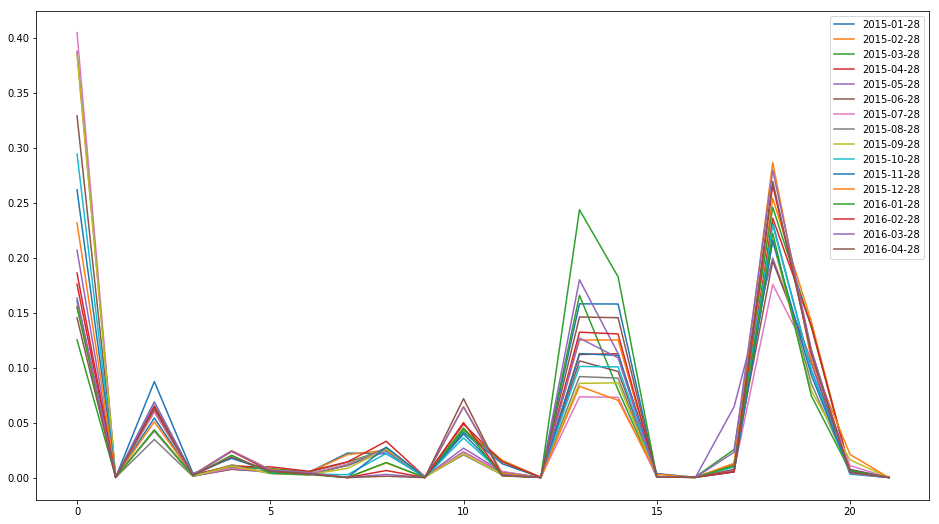

In [37]:
plt.figure(figsize=(16, 9))
for n in target_distribution:
    plt.plot(target_distribution.index, target_distribution[n]/target_distribution[n].sum(), label=n)
plt.legend()

In [33]:
target_distribution

,2015-01-28,2015-02-28,2015-03-28,2015-04-28,2015-05-28,2015-06-28,2015-07-28,2015-08-28,2015-09-28,2015-10-28,2015-11-28,2015-12-28,2016-01-28,2016-02-28,2016-03-28,2016-04-28
0,5831,5694,5335,5355,9457,15585,16559,20255,21727,13034,12096.0,8210.0,6546.0,7136.0,5761.0,5511.0
1,12,18,12,7,9,11,11,7,3,6,9.0,12.0,10.0,5.0,5.0,5.0
2,1964,1852,2068,1987,1934,2888,2448,1811,2450,3039,4033.0,2213.0,2260.0,2459.0,2424.0,2369.0
3,54,74,69,84,55,79,65,52,74,74,170.0,89.0,93.0,88.0,77.0,77.0
4,409,408,324,308,349,356,347,582,589,823,806.0,868.0,1061.0,913.0,854.0,713.0
5,261,292,282,298,222,265,231,191,224,209,283.0,259.0,217.0,225.0,240.0,226.0
6,174,167,173,174,154,165,145,122,153,140,155.0,149.0,141.0,131.0,161.0,131.0
7,808,763,485,435,503,526,508,581,472,115,8.0,0.0,1.0,0.0,0.0,0.0
8,786,906,880,1005,1085,1282,1073,1411,1472,971,1277.0,471.0,715.0,245.0,101.0,46.0
9,33,23,26,25,33,24,33,30,22,1,0.0,0.0,0.0,0.0,0.0,0.0
